In [9]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import helper as hp

import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.preprocessing import sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

## Data Loading

In [10]:
N_CATEGORY = 1

In [11]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Untaring file...


In [3]:
air_files = [f for f in os.listdir('./101_ObjectCategories/airplanes/')]
heli_files = [f for f in os.listdir('./101_ObjectCategories/helicopter/')]

N_TRAIN = 100

x_train = np.empty((N_TRAIN, 227, 227, 3), np.float32)
y_train = np.empty((N_TRAIN,), np.int8)

count = 0
for i in range(50):
    img = load_img( './101_ObjectCategories/airplanes/' + air_files[i])
    img = img.resize((227,227))
    
    x_train[count, :, :, :] = img
    y_train[count] = 1
    count += 1
    
    img = load_img( './101_ObjectCategories/helicopter/' + heli_files[i])
    img = img.resize((227,227))
    
    x_train[count, :, :, :] = img
    y_train[count] = -1
    count += 1 

In [4]:
N_TEST = 100

x_test = np.empty((N_TEST, 227, 227, 3), np.float32)
y_test = np.empty((N_TEST,), np.int8)

count = 0
for i in range(50, 80):
    img = load_img( './101_ObjectCategories/airplanes/' + air_files[i])
    img = img.resize((227,227))
    
    x_test[count, :, :, :] = img
    y_test[count] = 1
    count += 1
    
    img = load_img( './101_ObjectCategories/helicopter/' + heli_files[i])
    img = img.resize((227,227))
    
    x_test[count, :, :, :] = img
    y_test[count] = -1
    count += 1 

## AlexNet Architecture 

In [5]:
model_input = Input(shape = (227, 227, 3))

# First convolutional Layer (96x11x11)
z = Convolution2D(filters = 96, kernel_size = (11,11), 
                  strides = (4,4), activation = "relu")(model_input)
z = MaxPooling2D(pool_size = (3,3), strides=(2,2))(z)
z = BatchNormalization()(z)

# Second convolutional Layer (256x5x5)
z = ZeroPadding2D(padding = (2,2))(z)
z = Convolution2D(filters = 256, kernel_size = (5,5), 
                  strides = (1,1), activation = "relu")(z)
z = MaxPooling2D(pool_size = (3,3), strides=(2,2))(z)
z = BatchNormalization()(z)

# Rest 3 convolutional layers
z = ZeroPadding2D(padding = (1,1))(z)
z = Convolution2D(filters = 384, kernel_size = (3,3), 
                  strides = (1,1), activation = "relu")(z)

z = ZeroPadding2D(padding = (1,1))(z)
z = Convolution2D(filters = 384, kernel_size = (3,3), 
                  strides = (1,1), activation = "relu")(z)

z = ZeroPadding2D(padding = (1,1))(z)
z = Convolution2D(filters = 256, kernel_size = (3,3), 
                  strides = (1,1), activation = "relu")(z)

z = MaxPooling2D(pool_size = (3,3), strides=(2,2))(z)
z = Flatten()(z)
z = Dense(4096)(z)
z = Dense(4096)(z)
model_output = Dense(N_CATEGORY, activation="softmax")(z)

model = Model(model_input, model_output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 227, 227, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 31, 31, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 256)       0         
__________

In [6]:
import time
import pylab as pl
from IPython import display
pl.style.use('ggplot')
%matplotlib inline

class Histories(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
        self.val_loss = []
        self.val_acc = []

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs['acc'])
        self.loss.append(logs['loss'])
        self.val_acc.append(logs['val_acc'])
        self.val_loss.append(logs['val_loss'])
        
        pl.hold(True)
        pl.rc
        pl.plot(self.acc)
        pl.plot(self.loss)
        pl.plot(self.val_acc)
        pl.plot(self.val_loss)
        pl.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
        display.clear_output(wait=True)
        display.display(pl.gcf())
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

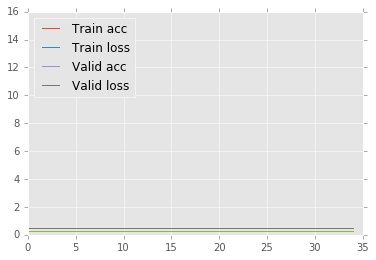

7s - loss: 15.9424 - acc: 0.5000 - val_loss: 15.9424 - val_acc: 0.3000
Epoch 36/100


KeyboardInterrupt: 

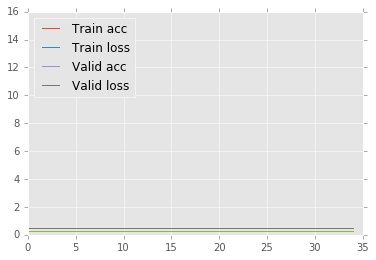

In [7]:
model.compile(loss="binary_crossentropy", optimizer=optimizers.SGD(0.01), metrics=["accuracy"])

histories = Histories()
res = model.fit(x_train, y_train,
          batch_size = 10,
          epochs=100, 
          validation_data = (x_test, y_test), verbose=2, callbacks=[histories])